In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [2]:
df = pd.read_csv('ulasan_digitalent.csv')
df.head()

,userName,score,content,at
0,Feby Ade,5,sangat menarik,2025-07-13 21:27:14
1,idham vidi tamuliko,2,loginnya ribet,2025-07-13 18:27:05
2,ari purnomo aji,5,bagus untuk pengembangan diri secara mandiri,2025-07-13 12:31:52
3,Cici Sukarsi,5,"program yg bagus, tolong dilanjutkan!",2025-07-12 15:30:07
4,Abdul Rohman,5,mantap,2025-07-10 20:14:32


In [4]:
if 'userName' in df.columns:
    df.drop(columns=['userName'], inplace=True)
if 'at' in df.columns:
    df.drop(columns=['at'], inplace=True)

df.head()

,score,content
0,5,sangat menarik
1,2,loginnya ribet
2,5,bagus untuk pengembangan diri secara mandiri
3,5,"program yg bagus, tolong dilanjutkan!"
4,5,mantap


In [9]:
stop_words = set(stopwords.words('indonesian'))

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'@\w+', '', text)  # hapus mention
    text = re.sub(r'\d+', '', text)   # hapus angka
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

df['cleaned'] = df['content'].apply(clean_text)
df.head()

,score,content,cleaned
0,5,sangat menarik,menarik
1,2,loginnya ribet,loginnya ribet
2,5,bagus untuk pengembangan diri secara mandiri,bagus pengembangan mandiri
3,5,"program yg bagus, tolong dilanjutkan!",program yg bagus tolong dilanjutkan
4,5,mantap,mantap


In [11]:
positive_words = ['bagus', 'mantap', 'baik', 'keren', 'suka', 'terbaik', 'cepat', 'bantu', 'puas']
negative_words = ['buruk', 'jelek', 'error', 'lambat', 'tidak bisa', 'gagal', 'payah', 'parah', 'mengecewakan', 'lemot']
neutral_words = ['biasa', 'cukup', 'standard', 'normal']

def label_sentiment(text):
    score = 0
    for word in text.split():
        if word in positive_words:
            score += 1
        elif word in negative_words:
            score -= 1
    if score > 0:
        return 2  # positif
    elif score < 0:
        return 0  # negatif
    else:
        return 1  # netral

df['sentiment'] = df['cleaned'].apply(label_sentiment)
df[['content', 'cleaned', 'sentiment']].head(10)

,content,cleaned,sentiment
0,sangat menarik,menarik,1
1,loginnya ribet,loginnya ribet,1
2,bagus untuk pengembangan diri secara mandiri,bagus pengembangan mandiri,2
3,"program yg bagus, tolong dilanjutkan!",program yg bagus tolong dilanjutkan,2
4,mantap,mantap,2
5,Aplikasi jelek,aplikasi jelek,0
6,"tolong untuk proses loginnya dipermudah, mungk...",tolong proses loginnya dipermudah sinkrone goo...,1
7,"aplikasinya bagus, membantu meningkatkan wawas...",aplikasinya bagus membantu meningkatkan wawasa...,2
8,"ga jelas, mau nasukin akun tapi isi data diri ...",ga nasukin akun isi data pas isi data ga nik t...,1
9,oke,oke,1


In [12]:
tokenizer = Tokenizer(num_words=8000, oov_token='<OOV>')
tokenizer.fit_on_texts(df['cleaned'])
sequences = tokenizer.texts_to_sequences(df['cleaned'])
padded = pad_sequences(sequences, maxlen=100)

X_train, X_test, y_train, y_test = train_test_split(padded, df['sentiment'], test_size=0.2, random_state=42)

In [13]:
model = Sequential()
model.add(Embedding(8000, 128, input_length=100))
model.add(LSTM(128, return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

e:\Tugas Kuliah\UAS Bayu Semester 4\UASV2(IPYNB)\.venv\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 147ms/step - accuracy: 0.6708 - loss: 0.7658 - val_accuracy: 0.9467 - val_loss: 0.2359
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 9s 114ms/step - accuracy: 0.9710 - loss: 0.1260 - val_accuracy: 0.9933 - val_loss: 0.0300
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 8s 111ms/step - accuracy: 0.9937 - loss: 0.0248 - val_accuracy: 0.9967 - val_loss: 0.0078
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 8s 109ms/step - accuracy: 0.9991 - loss: 0.0047 - val_accuracy: 1.0000 - val_loss: 0.0020
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 9s 123ms/step - accuracy: 1.0000 - loss: 0.0022 - val_accuracy: 1.0000 - val_loss: 9.6217e-04
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 9s 119ms/step - accuracy: 1.0000 - loss: 0.0017 - val_accuracy: 1.0000 - val_loss: 4.8476e-04
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 8s 108ms/step - accuracy: 1.0000 - loss: 7.3294e-04 - val_accuracy: 1.0000 - val_loss: 3.0710e-04
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 9s 121ms/step - accuracy: 1.0000 - loss: 4.9784e-

In [14]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred_classes, target_names=['Negatif', 'Netral', 'Positif']))
print('Akurasi Model:', round(accuracy_score(y_test, y_pred_classes) * 100, 2), '%')

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step
              precision    recall  f1-score   support

     Negatif       1.00      1.00      1.00        28
      Netral       1.00      1.00      1.00       388
     Positif       1.00      1.00      1.00       184

    accuracy                           1.00       600
   macro avg       1.00      1.00      1.00       600
weighted avg       1.00      1.00      1.00       600

Akurasi Model: 100.0 %


In [16]:
full_pred = model.predict(padded)
df['predicted_sentiment'] = np.argmax(full_pred, axis=1)

df[['content', 'cleaned', 'predicted_sentiment']].to_csv('ulasan_digitalent_labeled.csv', index=False, encoding='utf-8-sig')

df.head()

94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step


,score,content,cleaned,sentiment,predicted_sentiment
0,5,sangat menarik,menarik,1,1
1,2,loginnya ribet,loginnya ribet,1,1
2,5,bagus untuk pengembangan diri secara mandiri,bagus pengembangan mandiri,2,2
3,5,"program yg bagus, tolong dilanjutkan!",program yg bagus tolong dilanjutkan,2,2
4,5,mantap,mantap,2,2


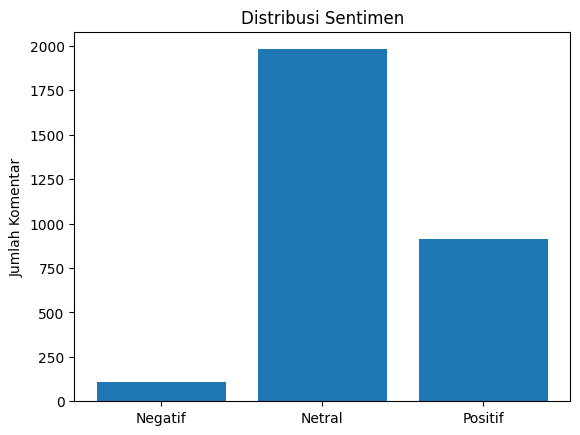

In [17]:
label_counts = df['predicted_sentiment'].value_counts().sort_index()
plt.bar(['Negatif', 'Netral', 'Positif'], label_counts)
plt.title('Distribusi Sentimen')
plt.ylabel('Jumlah Komentar')
plt.show()

In [30]:
label_map = {0: 'Negatif', 1: 'Netral', 2: 'Positif'}
print(df['cleaned'].map(label_map).value_counts())

Series([], Name: count, dtype: int64)


In [36]:
# Hitung distribusi label sentimen
print(df['predicted_sentiment'].value_counts().sort_index())

# Jika label awal (sebelum prediksi), gunakan:
print(df['cleaned'].value_counts().sort_index())


predicted_sentiment
0     108
1    1980
2     912
Name: count, dtype: int64
cleaned
akses lambat                                                                6
akses mudah tema pelatihan sesuai kebutuhan asn                             6
alhamdulillah sekolah terima kasih digitalent                               6
alhmdllah terbaik sukses                                                    6
amazing                                                                     6
                                                                           ..
utk                                                                         6
verifikasi loginnya susah banget                                            6
well done                                                                   6
ya aplikasi plat merah aja kendalanya aplikasi disuruh reset sandi error    6
yeah                                                                        6
Name: count, Length: 300, dtype: int64


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [21]:
df = pd.read_csv('ulasan_digitalent_labeled.csv')


In [25]:
print(df.columns)

Index(['content', 'cleaned', 'predicted_sentiment'], dtype='object')


In [26]:
texts = df['cleaned'].astype(str).tolist()
labels = df['predicted_sentiment'].astype(int).tolist()

In [27]:
tokenizer = Tokenizer(num_words=5000, oov_token='<OOV>')
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
padded_sequences = pad_sequences(sequences, maxlen=100)

In [28]:
X_train, X_val, y_train, y_val = train_test_split(
    padded_sequences,
    np.array(labels),
    test_size=0.2,
    stratify=labels,
    random_state=42
)

In [29]:
model = Sequential([
    Embedding(input_dim=5000, output_dim=64, input_length=100),
    LSTM(64),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


e:\Tugas Kuliah\UAS Bayu Semester 4\UASV2(IPYNB)\.venv\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [30]:
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stop]
)

Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - accuracy: 0.6526 - loss: -0.8351 - val_accuracy: 0.6600 - val_loss: -3.3554
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - accuracy: 0.6655 - loss: -3.7487 - val_accuracy: 0.6667 - val_loss: -4.8776
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.6664 - loss: -5.5187 - val_accuracy: 0.6717 - val_loss: -6.6780
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.6851 - loss: -6.8852 - val_accuracy: 0.6800 - val_loss: -8.3398
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - accuracy: 0.6780 - loss: -9.0223 - val_accuracy: 0.6967 - val_loss: -10.0380
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.6959 - loss: -10.1866 - val_accuracy: 0.6967 - val_loss: -11.5076
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.7098 - loss: -11.2985 - val_accuracy: 0.6967 - val_loss: -13.0126
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - accuracy: 0.6937 - loss: -13.5695 - val

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step


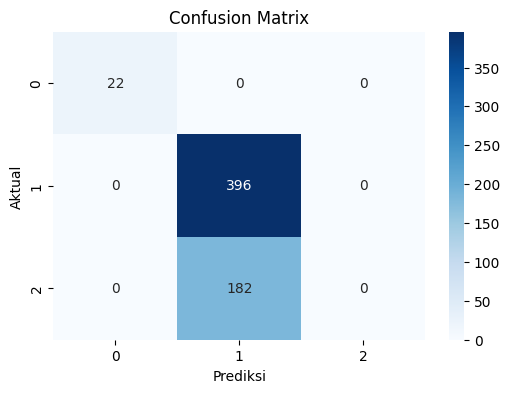

In [31]:
y_pred_prob = model.predict(X_val)
y_pred = (y_pred_prob > 0.5).astype(int)

# Confusion Matrix
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Prediksi')
plt.ylabel('Aktual')
plt.title('Confusion Matrix')
plt.show()

In [33]:
df = df[df['predicted_sentiment'] != 1]

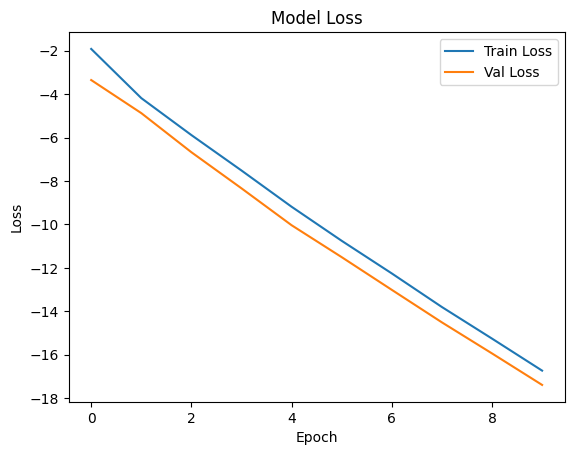

In [35]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

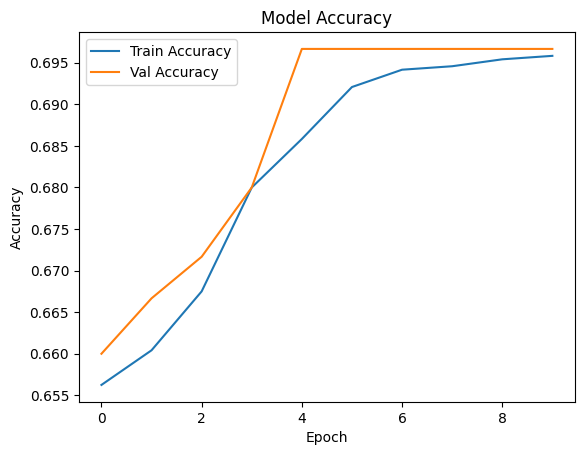

In [36]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()